In [22]:
#! pip install seaborn

Looking in indexes: http://pypi.douban.com/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.8/292.8 kB 1.8 MB/s eta 0:00:00 MB/s eta 0:00:01:01


In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from sklearn import tree
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
from tqdm import tqdm
import seaborn as sns

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device, ',', torch.__version__)

cuda:0 , 1.11.0+cu113


In [72]:
from collections import Counter

train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

print('train_data.shape =', train_data.shape)
print('test_data.shape =', test_data.shape)

unique_labels = train_data['label'].unique()
n_labels = len(unique_labels)
print('n_labels =', n_labels)

#print(Counter(train_data['label']))
# label_counts = train_data['label'].value_counts()
# label_counts

labels_id = dict(zip(unique_labels,range(n_labels)))

# label_counts.index
# label_counts.head()
# label_counts.tail()
# ax = label_counts.plot(y=label_counts, x=label_counts.index, title='test', kind='bar', figsize=(8,12))
# plt.show()

# plt.figure(figsize = (15,30))
# ax0 = sns.countplot(y=train_data['label'],order=label_counts.index)
# plt.show()

train_data.shape = (18353, 2)
test_data.shape = (8800, 1)
n_labels = 176


<class 'PIL.JpegImagePlugin.JpegImageFile'>


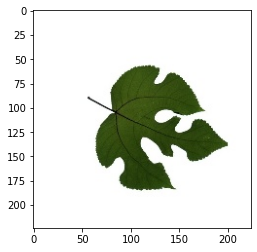

In [104]:
img = Image.open('./images/7.jpg')
plt.imshow(img)
plt.show()

<built-in method mode of Tensor object at 0x7f69bdc78d10>
<built-in method mode of Tensor object at 0x7f69bda3a4a0>
<built-in method mode of Tensor object at 0x7f69bdc92540>
<built-in method mode of Tensor object at 0x7f69bdb91220>
<built-in method mode of Tensor object at 0x7f69bdc1bbd0>
<built-in method mode of Tensor object at 0x7f69bdc3bb30>
<built-in method mode of Tensor object at 0x7f69bdc71360>
<built-in method mode of Tensor object at 0x7f69bdbe59f0>


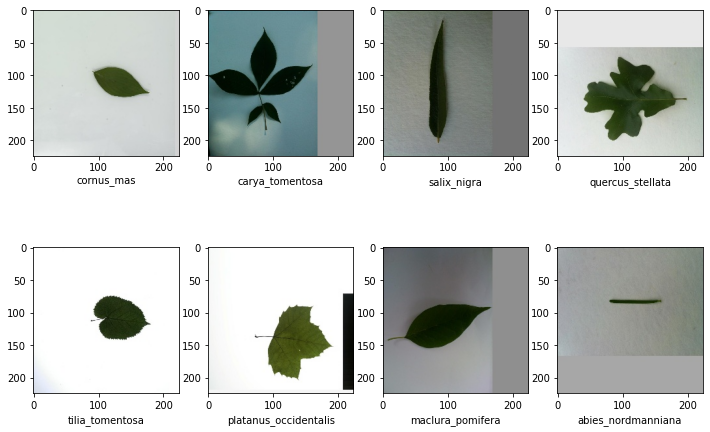

In [101]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class LeavesDataSet(Dataset):
    def __init__(self, cfg_path, mode, transform = None, target_transform = None):
        leaves_data = pd.read_csv(cfg_path)
        self.imgs = leaves_data['image']
        self.transform = transform
        self.target_transform = target_transform
        self.mode = mode
        if self.mode == 'train':
            self.labels = leaves_data['label']
        
    def __getitem__(self, index):
        img = Image.open(self.imgs[index])
        img = np.array(img)
        
        if self.transform:
            img = self.transform(img)
        
        if self.mode == 'train':
            label = int(labels_id[self.labels[index]])
            if self.target_transform:
                label = self.target_transform(label)
            return img,label
        return img
        
    def __len__(self):
        return len(self.imgs)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    ])

train_data = LeavesDataSet('./train.csv', 'train', transform=transform)
test_data = LeavesDataSet('./test.csv', 'test', transform=test_transform)
print(train_data)
print(test_data)

train_size = int(len(train_data)*0.8)
val_size = len(train_data) - train_size
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

assert(len(train_data) == train_size)
assert(len(val_data) == val_size)

img, label = train_data[0]
img.shape

# 看看数据长什么样
plt.figure(figsize=(12,8))
for i in range(2*4):
    img, label = train_data[i]
    axes = plt.subplot(2, 4, i+1)
    axes.set_xlabel(unique_labels[label])
    img = img.transpose(0, 2)
    plt.imshow(img)
plt.show()

In [74]:
#! pip install torchsummary

#加载预训练模型
from torchvision import models
from torchsummary import summary

def get_net(out_features):
    model = models.resnet50(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, out_features)
    return model

model = get_net(n_labels)
model = model.to(device)
# summary(model, (3, 224, 224))   

In [84]:
from tqdm import tqdm
# from torch.optim import lr_scheduler

batch_size, num_epochs, lr, weight_decay = 64, 30, 0.001, 1e-3

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=5)

val_loader = torch.utils.data.DataLoader(
    dataset=val_data,
    batch_size=batch_size,
    num_workers=5)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    num_workers=5)

print('train_loader.len =', len(train_loader))
print('val_loader.len =', len(val_loader))
print('test_loader.len =', len(test_loader))

train_loader.len = 230
val_loader.len = 58
test_loader.len = 138


In [76]:
def plot(data_list, label_list):
#     data_lst = [train_acc_list, val_acc_list, train_loss_list, val_loss_list]
#     label_lst = ['train_acc', 'val_acc', 'train_loss', 'val_loss']
#     print(data_lst)

    plt.figure(figsize=(12,8))
    for i in range(2):
        plt.subplot(1, 2, i+1)
        x = np.arange(1, num_epochs+1)
#         y = np.array(data_list[i*2:(i+1)*2]).reshape(num_epochs, -1)
        plt.plot(x, data_list[i*2], x, data_list[i*2+1])
        plt.xlim(1, num_epochs)
        plt.legend(label_list[i*2:(i+1)*2])
    plt.show()

100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.24it/s]


epoch = 1/30,  train_acc = 0.526688,  val_acc = 0.578266,  train_loss = 22.194728,  val_loss = 13.452388
saving model with acc 0.578


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.12it/s]


epoch = 2/30,  train_acc = 0.645846,  val_acc = 0.640766,  train_loss = 8.622515,  val_loss = 7.278534
saving model with acc 0.641


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.06it/s]


epoch = 3/30,  train_acc = 0.690338,  val_acc = 0.660970,  train_loss = 5.382028,  val_loss = 5.398650
saving model with acc 0.661


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.24it/s]


epoch = 4/30,  train_acc = 0.708722,  val_acc = 0.689796,  train_loss = 3.604562,  val_loss = 3.590281
saving model with acc 0.690


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 12.33it/s]


epoch = 5/30,  train_acc = 0.737589,  val_acc = 0.694797,  train_loss = 2.264534,  val_loss = 2.617703
saving model with acc 0.695


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.43it/s]


epoch = 6/30,  train_acc = 0.753381,  val_acc = 0.708326,  train_loss = 1.698476,  val_loss = 2.199044
saving model with acc 0.708


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.15it/s]


epoch = 7/30,  train_acc = 0.773495,  val_acc = 0.724009,  train_loss = 1.402343,  val_loss = 1.975861
saving model with acc 0.724


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.09it/s]


epoch = 8/30,  train_acc = 0.780017,  val_acc = 0.732782,  train_loss = 1.227331,  val_loss = 1.773129
saving model with acc 0.733


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.46it/s]


epoch = 9/30,  train_acc = 0.787861,  val_acc = 0.733860,  train_loss = 1.048799,  val_loss = 1.594441
saving model with acc 0.734


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.33it/s]


epoch = 10/30,  train_acc = 0.799880,  val_acc = 0.750234,  train_loss = 0.921538,  val_loss = 1.379311
saving model with acc 0.750


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 10.94it/s]


epoch = 11/30,  train_acc = 0.809020,  val_acc = 0.737420,  train_loss = 0.826347,  val_loss = 1.318779


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.51it/s]


epoch = 12/30,  train_acc = 0.820051,  val_acc = 0.755681,  train_loss = 0.713844,  val_loss = 1.170334
saving model with acc 0.756


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 10.47it/s]


epoch = 13/30,  train_acc = 0.829222,  val_acc = 0.752179,  train_loss = 0.646338,  val_loss = 1.148947


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 11.60it/s]


epoch = 14/30,  train_acc = 0.827331,  val_acc = 0.768612,  train_loss = 0.606435,  val_loss = 0.968757
saving model with acc 0.769


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.20it/s]


epoch = 15/30,  train_acc = 0.840970,  val_acc = 0.776096,  train_loss = 0.544752,  val_loss = 0.935779
saving model with acc 0.776


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.56it/s]


epoch = 16/30,  train_acc = 0.843891,  val_acc = 0.773941,  train_loss = 0.519678,  val_loss = 0.894986


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 10.65it/s]


epoch = 17/30,  train_acc = 0.845694,  val_acc = 0.765110,  train_loss = 0.497890,  val_loss = 0.898048


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.24it/s]


epoch = 18/30,  train_acc = 0.849535,  val_acc = 0.773402,  train_loss = 0.489322,  val_loss = 0.850530


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.29it/s]


epoch = 19/30,  train_acc = 0.845292,  val_acc = 0.778369,  train_loss = 0.496930,  val_loss = 0.796982
saving model with acc 0.778


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.22it/s]


epoch = 20/30,  train_acc = 0.859255,  val_acc = 0.761818,  train_loss = 0.462672,  val_loss = 0.852992


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.52it/s]


epoch = 21/30,  train_acc = 0.862145,  val_acc = 0.775019,  train_loss = 0.467045,  val_loss = 0.773186


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 11.71it/s]


epoch = 22/30,  train_acc = 0.863801,  val_acc = 0.785045,  train_loss = 0.466192,  val_loss = 0.749872
saving model with acc 0.785


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.44it/s]


epoch = 23/30,  train_acc = 0.862584,  val_acc = 0.772864,  train_loss = 0.477913,  val_loss = 0.809152


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.88it/s]


epoch = 24/30,  train_acc = 0.867172,  val_acc = 0.788430,  train_loss = 0.480249,  val_loss = 0.737116
saving model with acc 0.788


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.87it/s]


epoch = 25/30,  train_acc = 0.865400,  val_acc = 0.788219,  train_loss = 0.492438,  val_loss = 0.755799


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.67it/s]


epoch = 26/30,  train_acc = 0.872392,  val_acc = 0.767476,  train_loss = 0.485477,  val_loss = 0.824988


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.41it/s]


epoch = 27/30,  train_acc = 0.870830,  val_acc = 0.783487,  train_loss = 0.496840,  val_loss = 0.793746


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 13.57it/s]


epoch = 28/30,  train_acc = 0.860378,  val_acc = 0.779774,  train_loss = 0.523577,  val_loss = 0.809476


100%|███████████████████████████████████████████| 58/58 [00:04<00:00, 14.03it/s]


epoch = 29/30,  train_acc = 0.867679,  val_acc = 0.774328,  train_loss = 0.516018,  val_loss = 0.813799


100%|███████████████████████████████████████████| 58/58 [00:05<00:00, 11.11it/s]


epoch = 30/30,  train_acc = 0.866419,  val_acc = 0.775253,  train_loss = 0.525499,  val_loss = 0.815437
[[0.526687918279482, 0.6458455269751342, 0.6903375838113868, 0.7087217810361282, 0.7375888378723808, 0.7533810620722563, 0.7734949834968733, 0.780016722627308, 0.7878605770028155, 0.7998798077521116, 0.8090196490287781, 0.8200512124144512, 0.8292224080666252, 0.8273306856984678, 0.8409698999446371, 0.8438910955968111, 0.8456939800925877, 0.8495349080666251, 0.8452915971693785, 0.8592548077521117, 0.8621446490287781, 0.8638012124144513, 0.8625836120999377, 0.8671718229418216, 0.8654002928215524, 0.8723923496578051, 0.8708298496578051, 0.860378344680952, 0.8676787207955899, 0.8664193145606829], [0.5782655549460444, 0.6407655549460444, 0.6609702963253548, 0.6897957273598375, 0.6947971325496147, 0.7083255247823124, 0.724009089428803, 0.7327820463427182, 0.7338596325496147, 0.7502342585859627, 0.7374203523685192, 0.7556807532392699, 0.7521785980668562, 0.7686117877220285, 0.77609632755148

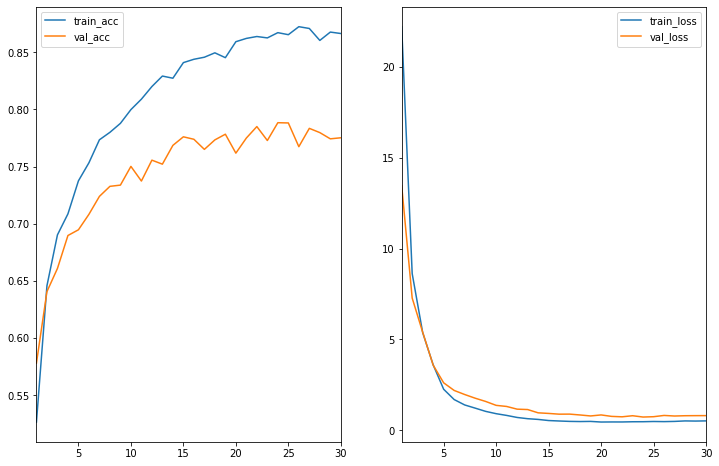

In [49]:
# my train and validition code
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

train_acc_list, train_loss_list = [],[]
val_acc_list, val_loss_list = [],[]

best_acc = 0.0
model_path = './my_pre_res_model.ckpt'

# for epoch in tqdm(range(num_epochs)):
for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    
    # train
    model.train()
    for (img, label) in tqdm(train_loader):
        img,label = img.to(device),label.to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = loss_fn(y_pred, label)
        loss.backward()
        optimizer.step()
        
        y_pred = torch.argmax(y_pred, dim=-1)
        train_acc += (y_pred == label).float().mean().item()
        train_loss += loss.item()

    train_acc_list.append(train_acc/len(train_loader))
    train_loss_list.append(train_loss/len(train_loader))

    # validition
    model.eval()
    for (img, label) in tqdm(val_loader):
        img,label = img.to(device),label.to(device)
        
        with torch.no_grad():
            y_pred = model(img)
            loss = loss_fn(y_pred, label)
            y_pred = torch.argmax(y_pred, dim=-1)
            val_acc += (y_pred == label).float().mean().item()
            val_loss += loss.item()

    val_acc_list.append(val_acc/len(val_loader))
    val_loss_list.append(val_loss/len(val_loader))
            
    print(f'epoch = {epoch+1}/{num_epochs},\
          train_acc = {float(train_acc_list[-1]):02f},\
          val_acc = {float(val_acc_list[-1]):02f},\
          train_loss = {float(train_loss_list[-1]):02f},\
          val_loss = {float(val_loss_list[-1]):02f}'.replace('        ', ''))

    # if the model improves, save a checkpoint at this epoch
    if val_acc_list[-1] > best_acc:
        best_acc = val_acc_list[-1]
        torch.save(model.state_dict(), model_path)
        print(f'saving model with acc {best_acc:.3f}')
#         print('saving model with acc {:.3f}'.format(best_acc))
    
# from d2l import torch as d2l

# d2l.plot(np.arange(1, num_epochs+1),
#         [train_acc_list, val_acc_list],
#         xlabel='epoch', xlim=[1, num_epochs],
#         legend=['train_acc','val_acc'])

# d2l.plot(np.arange(1, num_epochs+1),
#         [train_loss_list, val_loss_list],
#         xlabel='epoch', xlim=[1, num_epochs],
#         legend=['train_loss', 'val_loss'])

data_lst = [train_acc_list, val_acc_list, train_loss_list, val_loss_list]
label_lst = ['train_acc', 'val_acc', 'train_loss', 'val_loss']
print(data_lst)

plot(data_lst, label_lst)

# plt.figure(figsize=(12,8))
# for i in range(2):
#     plt.subplot(1, 2, i+1)
#     x = np.arange(1, num_epochs+1)
#     y = np.array(data_lst[i*2:(i+1)*2]).reshape(num_epochs, -1)
#     plt.plot(x, y)
#     plt.xlim(1, num_epochs)
#     plt.legend(label_lst[i*2:(i+1)*2])
# plt.show()

In [98]:
# predict
model = get_net(n_labels)
model = model.to(device)

model.load_state_dict(torch.load(model_path))

# img,_ = test_data[0]

num_preds = []
for img in tqdm(test_loader):
    img = img.to(device)
    
    with torch.no_grad():
        pred = torch.argmax(model(img), dim=-1).cpu().numpy().tolist()
        num_preds += pred

test_data = pd.read_csv('./test.csv')
test_data['label'] = pd.Series(num_preds).apply(lambda x: unique_labels[x])
# test_data['label'] = pd.Series(num_preds).apply(lambda x: unique_labels[x])
# test_data['label']

test_data
# submission = pd.concat([test_data['image'], test_data['label']], axis=1)
# submission.to_csv('submission.csv', index=False)
    

100%|█████████████████████████████████████████| 138/138 [00:11<00:00, 11.97it/s]


,image,label
0,images/18353.jpg,asimina_triloba
1,images/18354.jpg,aesculus_hippocastamon
2,images/18355.jpg,platanus_acerifolia
3,images/18356.jpg,pinus_bungeana
4,images/18357.jpg,platanus_acerifolia
...,...,...
8795,images/27148.jpg,pinus_wallichiana
8796,images/27149.jpg,amelanchier_arborea
8797,images/27150.jpg,pinus_resinosa
8798,images/27151.jpg,cercis_canadensis


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.49it/s]


[ Train | 001/010 ] loss = 2.56016, acc = 0.96712


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.58it/s]


[ Valid | 001/010 ] loss = 17.82148, acc = 0.86452
saving model with acc 0.865


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.71it/s]


[ Train | 002/010 ] loss = 2.50818, acc = 0.96746


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 21.64it/s]


[ Valid | 002/010 ] loss = 16.45687, acc = 0.87539
saving model with acc 0.875


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.29it/s]


[ Train | 003/010 ] loss = 2.12787, acc = 0.97215


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.22it/s]


[ Valid | 003/010 ] loss = 20.19511, acc = 0.86262


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.26it/s]


[ Train | 004/010 ] loss = 1.80378, acc = 0.97364


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 21.39it/s]


[ Valid | 004/010 ] loss = 14.68972, acc = 0.87826
saving model with acc 0.878


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.48it/s]


[ Train | 005/010 ] loss = 2.51876, acc = 0.96812


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.48it/s]


[ Valid | 005/010 ] loss = 16.23600, acc = 0.87349


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.33it/s]


[ Train | 006/010 ] loss = 2.55074, acc = 0.96451


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 21.97it/s]


[ Valid | 006/010 ] loss = 16.82171, acc = 0.85566


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.57it/s]


[ Train | 007/010 ] loss = 2.04558, acc = 0.97195


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.17it/s]


[ Valid | 007/010 ] loss = 15.81255, acc = 0.86881


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.60it/s]


[ Train | 008/010 ] loss = 2.01691, acc = 0.97008


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.70it/s]


[ Valid | 008/010 ] loss = 15.26284, acc = 0.87533


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.34it/s]


[ Train | 009/010 ] loss = 1.48656, acc = 0.97861


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 22.34it/s]


[ Valid | 009/010 ] loss = 18.21498, acc = 0.86576


100%|█████████████████████████████████████████| 459/459 [00:18<00:00, 24.58it/s]


[ Train | 010/010 ] loss = 2.01236, acc = 0.97161


100%|█████████████████████████████████████████| 115/115 [00:05<00:00, 21.71it/s]


[ Valid | 010/010 ] loss = 16.56538, acc = 0.87420
[[0.9671160130718954, 0.9674564270152506, 0.9721541394335512, 0.9736362494414669, 0.9681215435591138, 0.9645131557595497, 0.9719498910675382, 0.9700802330877266, 0.9786062930144516, 0.971609477124183], [0.864520321721616, 0.8753898869390073, 0.8626181478085725, 0.8782608695652174, 0.8734877130259638, 0.8556592630303425, 0.8688090739042863, 0.875330813034721, 0.8657608695652174, 0.8741965972858926], [2.5601555630174304, 2.5081838611372103, 2.127874914305006, 1.8037794783677963, 2.5187588435620367, 2.550744818229241, 2.045581430927872, 2.016913345166769, 1.4865609517749871, 2.012361785395731], [17.821478705885617, 16.456869541096967, 20.1951056184976, 14.689724582491909, 16.23600123340021, 16.82170777320862, 15.812546822299128, 15.262837056491685, 18.2149804413926, 16.56538442010465]]


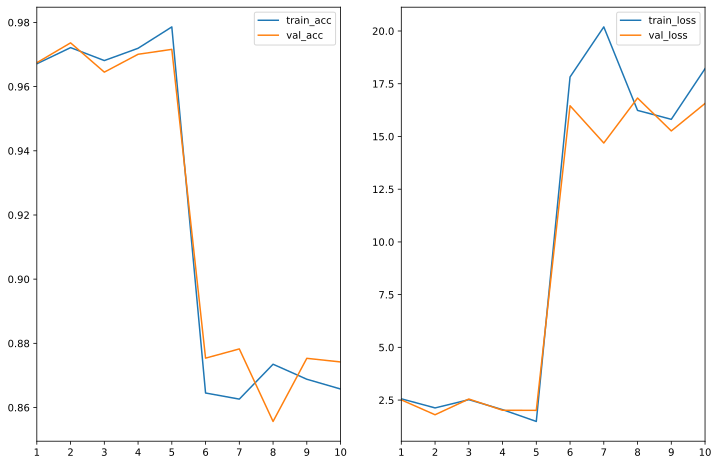

In [163]:
# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

model_path = './pre_res_model.ckpt'

train_acc_list, val_acc_list, train_loss_list, val_loss_list = [],[],[],[]

best_acc = 0.0
for epoch in range(num_epochs):
    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train() 
    # These are used to record information in training.
    train_loss = []
    train_accs = []
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs)
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels)
        
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()
        # Compute the gradients for parameters.
        loss.backward()
        # Update the parameters with computed gradients.
        optimizer.step()
        
        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels).float().mean().item()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{num_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()
    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []
    
    # Iterate the validation set by batches.
    for batch in tqdm(val_loader):
        imgs, labels = batch
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))
            
        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean().item()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        
    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    val_acc_list.append(valid_acc)
    val_loss_list.append(valid_loss)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{num_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    
    # if the model improves, save a checkpoint at this epoch
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print('saving model with acc {:.3f}'.format(best_acc))
        
data_lst = [train_acc_list, val_acc_list, train_loss_list, val_loss_list]
label_lst = ['train_acc', 'val_acc', 'train_loss', 'val_loss']
print(data_lst)

plot(data_lst, label_lst)

In [18]:
# data_lst = [train_acc_list, train_loss_list, val_acc_list, val_loss_list]
label_lst = ['train_acc', 'val_acc', 'train_loss', 'val_loss']
data_lst = [
        [0.9671160130718954, 0.9674564270152506, 0.9721541394335512, 0.9736362494414669, 0.9681215435591138, 0.9645131557595497, 0.9719498910675382, 0.9700802330877266, 0.9786062930144516, 0.971609477124183],
        [0.864520321721616, 0.8753898869390073, 0.8626181478085725, 0.8782608695652174, 0.8734877130259638, 0.8556592630303425, 0.8688090739042863, 0.875330813034721, 0.8657608695652174, 0.8741965972858926],
        [2.5601555630174304, 2.5081838611372103, 2.127874914305006, 1.8037794783677963, 2.5187588435620367, 2.550744818229241, 2.045581430927872, 2.016913345166769, 1.4865609517749871, 2.012361785395731],
        [17.821478705885617, 16.456869541096967, 20.1951056184976, 14.689724582491909, 16.23600123340021, 16.82170777320862, 15.812546822299128, 15.262837056491685, 18.2149804413926, 16.56538442010465]
]

x = np.arange(1,num_epochs+1)
print(x.shape)
print(np.array(data_lst[0:2]).reshape(10,-1).shape)
print(np.array(data_lst[0:2]))
print('================')
print(np.array(data_lst[0:2]).reshape(10,-1))

# plt.plot(np.arange(1,num_epochs+1), data_lst[0], np.arange(1,num_epochs+1), data_lst[1])
# plt.legend(['train_acc', 'val_acc'])
# plt.show()

# plt.figure(figsize=(12,8))
# for i in range(2):
#     plt.subplot(2, 2, i+1)
#     x = np.arange(1,num_epochs+1)
#     plt.plot(x, data_lst[i*2], x, data_lst[i*2+1])
#     plt.xlim(1, num_epochs)
#     plt.legend(label_lst[i*2:(i+1)*2])
# plt.show()

# plt.subplot(1, 2, 2)
# plt.plot(x,y)
# plt.title("plot 2")

# for i in range(4):
#     plt.subplot(2, 2, i+1)
#     plt.plot(np.arange(1,3), y)
#     plt.legend(['x', 'y'])
# plt.show()

print(f'epoch = {11},\
      train_acc = {float(data_lst[0][-1]):02f},\
      val_acc = {float(data_lst[1][-1]):02f},\
      train_loss = {float(data_lst[2][-1]):02f},\
      val_loss = {float(data_lst[3][-1]):02f}'.replace('     ', ''))

(50,)
(10, 2)
[[0.96711601 0.96745643 0.97215414 0.97363625 0.96812154 0.96451316
  0.97194989 0.97008023 0.97860629 0.97160948]
 [0.86452032 0.87538989 0.86261815 0.87826087 0.87348771 0.85565926
  0.86880907 0.87533081 0.86576087 0.8741966 ]]
[[0.96711601 0.96745643]
 [0.97215414 0.97363625]
 [0.96812154 0.96451316]
 [0.97194989 0.97008023]
 [0.97860629 0.97160948]
 [0.86452032 0.87538989]
 [0.86261815 0.87826087]
 [0.87348771 0.85565926]
 [0.86880907 0.87533081]
 [0.86576087 0.8741966 ]]
epoch = 11, train_acc = 0.971609, val_acc = 0.874197, train_loss = 2.012362, val_loss = 16.565384
